In [1]:
# Necessary libraries
import numpy as np 
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

import warnings 
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from numpy import asarray
from collections import Counter
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/sample_submission.csv
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/Urun Ozellikleri.xlsx
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv")
test_data = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv")

df_train = train_data.copy()
df_test = test_data.copy()

In [3]:
# Eksik degerleri imputer ile doldurma, iterasyon 10
# iterasyon artisi pek bir degisim olusturmuyor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

columns_to_impute = [
    "SORU_MEDENI_HAL_RG", "SORU_GELIR_RG", "SORU_COCUK_SAYISI_CVP", "SORU_COCUK_SAYISI_RG", "SORU_EGITIM_RG", 
    "SON_AY_KATKI_ADET", "SON_AY_KATKI_MIKTARI", "SON_CEYREK_KATKI_ADET", "SON_SENE_KATKI_ADET",
    "SON_CEYREK_KATKI_MIKTARI", "SON_SENE_KATKI_ADET", "SON_SENE_KATKI_MIKTARI", "SORU_YATIRIM_KARAKTERI_RG"
]

imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0)

df_train[columns_to_impute] = imputer.fit_transform(df_train[columns_to_impute]).astype(int)
df_test[columns_to_impute] = imputer.transform(df_test[columns_to_impute]).astype(int)

In [4]:
# Rastgele degerler ile doldur
def fill_missing_values_randomly(df, column_name):
    non_missing_values = df[column_name].dropna().unique()
    df[column_name] = df[column_name].apply(
        lambda x: np.random.choice(non_missing_values) if pd.isnull(x) else x
    )

def fill_columns_randomly(df):
    columns_to_fill = [
        'SORU_EGITIM_CVP',
        'SORU_YATIRIM_KARAKTERI_CVP',
        'SORU_MEDENI_HAL_CVP',
        'PP_MESLEK'
    ]
    
    for column in columns_to_fill:
        fill_missing_values_randomly(df, column)

fill_columns_randomly(df_train)
fill_columns_randomly(df_test)

In [5]:
# MICE imputer
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

# Kategorik sutunlar
categorical_columns = [
    "SORU_GELIR_CVP"
]

for column in categorical_columns:
    df_train[column] = df_train[column].astype(str).str.replace(',', '.').astype(float)
    df_test[column] = df_test[column].astype(str).str.replace(',', '.').astype(float)

# MICE model
class CategoricalImputerMICE(IterativeImputer):
    def __init__(self, **kwargs):
        super().__init__(estimator=RandomForestClassifier(), **kwargs)
    
    def round_results(self, X):
        return np.around(X)

    def transform(self, X):
        imputed_data = super().transform(X)
        return self.round_results(imputed_data)

    def fit_transform(self, X, y=None):
        imputed_data = super().fit_transform(X, y)
        return self.round_results(imputed_data)

imputer = CategoricalImputerMICE(max_iter=10, random_state=0)

df_train[categorical_columns] = imputer.fit_transform(df_train[categorical_columns])
df_test[categorical_columns] = imputer.transform(df_test[categorical_columns])

In [6]:
df_train = df_train.drop(columns = ["MUSTERI_ID"])

In [7]:
# Hedef degisken asiri dengesiz
df_train['LABEL'].value_counts()

LABEL
UA      832770
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: count, dtype: int64

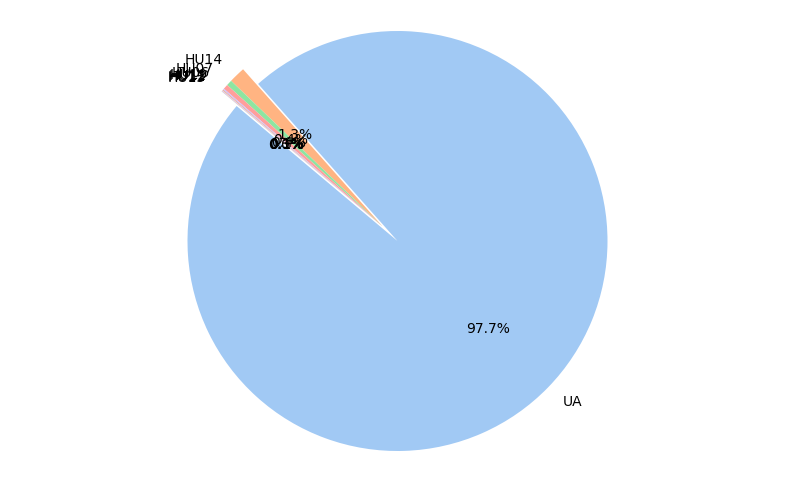

In [8]:
label = df_train['LABEL'].value_counts().head(10)
explode_values = (0.1, 0, 0, 0, 0, 0, 0, 0)

plt.figure(figsize=(10, 6))
plt.pie(label, labels=label.index, autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette('pastel'), explode=explode_values)
plt.axis('equal')  
plt.show()

# FEATURE ENGINEERING

In [9]:
# Yas normalizasyonu
df_train["YAS"] = df_train["PP_YAS"] // 12
df_test["YAS"] = df_test["PP_YAS"] // 12

# drop PP_YAS
df_train = df_train.drop(columns = "PP_YAS")
df_test = df_test.drop(columns = "PP_YAS")

# Yas kategori gruplama
def yas_aralik(yas):
    if yas <= 18:
        return "Çocuk"
    elif 18 < yas <= 30:
        return "Genç Yetişkin"
    elif 30 < yas <= 65:
        return "Yetişkin"
    else:
        return "Yaşlı"

df_train["YAS_ARALIK"] = df_train["YAS"].apply(yas_aralik)
df_test["YAS_ARALIK"] = df_test["YAS"].apply(yas_aralik)

df_train = df_train.drop(columns = "YAS")
df_test = df_test.drop(columns = "YAS")

# Encode YAS_ARALIK
yas_aralik_kod = {'Çocuk':0, 'Genç Yetişkin':1,'Yetişkin':2,'Yaşlı':3}
df_train['YAS_ARALIK'] = df_train['YAS_ARALIK'].map(yas_aralik_kod)
df_test['YAS_ARALIK'] = df_test['YAS_ARALIK'].map(yas_aralik_kod)

In [10]:
# Cocuk siniflama
def cocuk_varmi(cocuk_sayisi):
    if cocuk_sayisi > 0:
        return "Var"
    elif cocuk_sayisi == 0:
        return "Yok"

df_train["COCUK_SAHIPLIK"] = df_train["SORU_COCUK_SAYISI_CVP"].apply(cocuk_varmi)
df_test["COCUK_SAHIPLIK"] = df_test["SORU_COCUK_SAYISI_CVP"].apply(cocuk_varmi)

# Encoding COCUK_SAHIPLIK
cocuk_sahiplik = {'Yok':0, 'Var':1}
df_train['COCUK_SAHIPLIK'] = df_train['COCUK_SAHIPLIK'].map(cocuk_sahiplik)
df_test['COCUK_SAHIPLIK'] = df_test['COCUK_SAHIPLIK'].map(cocuk_sahiplik)

# Plaka bolge siniflandirmasi
plaka_bolge_sozlugu = {
    1: "Akdeniz_Bölgesi", 7: "Akdeniz_Bölgesi", 15: "Akdeniz_Bölgesi", 31: "Akdeniz_Bölgesi", 
    32: "Akdeniz_Bölgesi", 46: "Akdeniz_Bölgesi", 33: "Akdeniz_Bölgesi", 80: "Akdeniz_Bölgesi",
    4: "Doğu_Anadolu_Bölgesi", 75: "Doğu_Anadolu_Bölgesi", 12: "Doğu_Anadolu_Bölgesi", 13: "Doğu_Anadolu_Bölgesi", 
    23: "Doğu_Anadolu_Bölgesi", 24: "Doğu_Anadolu_Bölgesi", 25: "Doğu_Anadolu_Bölgesi", 30: "Doğu_Anadolu_Bölgesi", 
    76: "Doğu_Anadolu_Bölgesi", 36: "Doğu_Anadolu_Bölgesi", 44: "Doğu_Anadolu_Bölgesi", 49: "Doğu_Anadolu_Bölgesi", 
    62: "Doğu_Anadolu_Bölgesi", 65: "Doğu_Anadolu_Bölgesi",
    3: "Ege_Bölgesi", 9: "Ege_Bölgesi", 20: "Ege_Bölgesi", 35: "Ege_Bölgesi", 
    43: "Ege_Bölgesi", 45: "Ege_Bölgesi", 48: "Ege_Bölgesi", 64: "Ege_Bölgesi",
    2: "Güneydoğu_Anadolu_Bölgesi", 72: "Güneydoğu_Anadolu_Bölgesi", 21: "Güneydoğu_Anadolu_Bölgesi", 27: "Güneydoğu_Anadolu_Bölgesi", 
    79: "Güneydoğu_Anadolu_Bölgesi", 47: "Güneydoğu_Anadolu_Bölgesi", 56: "Güneydoğu_Anadolu_Bölgesi", 63: "Güneydoğu_Anadolu_Bölgesi", 
    73: "Güneydoğu_Anadolu_Bölges",
    68: "İç_Anadolu_Bölgesi", 6: "İç_Anadolu_Bölgesi", 18: "İç_Anadolu_Bölgesi", 26: "İç_Anadolu_Bölgesi", 
    70: "İç_Anadolu_Bölgesi", 38: "İç_Anadolu_Bölgesi", 71: "İç_Anadolu_Bölgesi", 40: "İç_Anadolu_Bölgesi", 
    42: "İç_Anadolu_Bölgesi", 50: "İç_Anadolu_Bölgesi", 51: "İç_Anadolu_Bölgesi", 58: "İç_Anadolu_Bölgesi", 
    66: "İç_Anadolu_Bölgesi",
    5: "Karadeniz_Bölgesi", 8: "Karadeniz_Bölgesi", 74: "Karadeniz_Bölgesi", 69: "Karadeniz_Bölgesi", 
    14: "Karadeniz_Bölgesi", 19: "Karadeniz_Bölgesi", 81: "Karadeniz_Bölgesi", 28: "Karadeniz_Bölgesi", 
    29: "Karadeniz_Bölgesi", 78: "Karadeniz_Bölgesi", 37: "Karadeniz_Bölgesi", 52: "Karadeniz_Bölgesi", 
    53: "Karadeniz_Bölgesi", 55: "Karadeniz_Bölgesi", 57: "Karadeniz_Bölgesi", 60: "Karadeniz_Bölgesi", 
    61: "Karadeniz_Bölgesi", 67: "Karadeniz_Bölgesi",
    10: "Marmara_Bölgesi", 11: "Marmara_Bölgesi", 16: "Marmara_Bölgesi", 17: "Marmara_Bölgesi", 
    22: "Marmara_Bölgesi", 34: "Marmara_Bölgesi", 39: "Marmara_Bölgesi", 41: "Marmara_Bölgesi", 
    54: "Marmara_Bölgesi", 59: "Marmara_Bölgesi", 77: "Marmara_Bölgesi",
    0: "Yurtdışı"
}

df_train['BOLGE'] = df_train['IL'].map(plaka_bolge_sozlugu)
df_test['BOLGE'] = df_test['IL'].map(plaka_bolge_sozlugu)

# Encoding BOLGE
bolge_kod = {'Yurtdışı':0, 'Marmara_Bölgesi':1,'İç_Anadolu_Bölgesi':2,'Ege_Bölgesi':3,'Akdeniz_Bölgesi':4,'Karadeniz_Bölgesi':5,'Güneydoğu_Anadolu_Bölgesi':6, 'Doğu_Anadolu_Bölgesi': 7}
df_train['BOLGE'] = df_train['BOLGE'].map(bolge_kod)
df_test['BOLGE'] = df_test['BOLGE'].map(bolge_kod)

# Drop IL
df_train = df_train.drop(columns = "IL")
df_test = df_test.drop(columns = "IL")

# Encoding ve siniflandirma YUKSEK_DUSUK_BILGI_TALEBI
ortalama_bilgi_talebi = df_train["BILGI_TALEP_ADET"].mean()
df_train["YUKSEK_DUSUK_BILGI_TALEBI"] = df_train["BILGI_TALEP_ADET"].apply(lambda x: "Yüksek" if x > ortalama_bilgi_talebi else "Düşük")
df_test["YUKSEK_DUSUK_BILGI_TALEBI"] = df_test["BILGI_TALEP_ADET"].apply(lambda x: "Yüksek" if x > ortalama_bilgi_talebi else "Düşük")
bilgi_talep = {'Düşük':0, 'Yüksek':1}
df_train['YUKSEK_DUSUK_BILGI_TALEBI'] = df_train['YUKSEK_DUSUK_BILGI_TALEBI'].map(bilgi_talep)
df_test['YUKSEK_DUSUK_BILGI_TALEBI'] = df_test['YUKSEK_DUSUK_BILGI_TALEBI'].map(bilgi_talep)

In [11]:
# Encoding LABEL
LABEL_ENCODE = {'UA':0, 'HU14':1,'HU07':2,'HU06':3,'HU19':4,'HU12':5,'HU11':6, 'HU15': 7}
df_train['LABEL'] = df_train['LABEL'].map(LABEL_ENCODE)

In [12]:
# Encoding AY
AY_train = {'MAYIS':1, 'HAZIRAN':2,'TEMMUZ':3,'AGUSTOS':4,'EYLUL':5,'EKIM':6}
df_train['FLAG'] = df_train['FLAG'].map(AY_train)
AY_test = {'KASIM':7, 'ARALIK':8}
df_test['FLAG'] = df_test['FLAG'].map(AY_test)

# PP_MESLEK gruplama
df_train["PP_MESLEK"] = df_train['PP_MESLEK'].mask(df_train['PP_MESLEK'].map(df_train['PP_MESLEK'].value_counts(normalize=True)) < 0.02, 'Diğer')
df_test["PP_MESLEK"] = df_test['PP_MESLEK'].mask(df_test['PP_MESLEK'].map(df_test['PP_MESLEK'].value_counts(normalize=True)) < 0.02, 'Diğer')

#MESLEK_ENCODE = {'Diğer':0, 'İşçi':1,'Öğrenci':2,'Ev Hanımı':3,'Öğretmen':4,'Esnaf':5, 'Memur':6, 'Serbest Meslek':7, 'Mühendis':8}
#df_train['PP_MESLEK'] = df_train['PP_MESLEK'].map(MESLEK_ENCODE)
#df_test['PP_MESLEK'] = df_test['PP_MESLEK'].map(MESLEK_ENCODE)

# SORU_MEDENI_HAL_CVP encoding ve gruplama  
df_train["SORU_MEDENI_HAL_CVP"] = df_train['SORU_MEDENI_HAL_CVP'].mask(df_train['SORU_MEDENI_HAL_CVP'].map(df_train['SORU_MEDENI_HAL_CVP'].value_counts(normalize=True)) < 0.02, 'Other')
df_test["SORU_MEDENI_HAL_CVP"] = df_test['SORU_MEDENI_HAL_CVP'].mask(df_test['SORU_MEDENI_HAL_CVP'].map(df_test['SORU_MEDENI_HAL_CVP'].value_counts(normalize=True)) < 0.02, 'Other')

MEDENIHAL_ENCODE = {'Other':0, 'Single':1,'Married':2,'Divorced':3}
df_train['SORU_MEDENI_HAL_CVP'] = df_train['SORU_MEDENI_HAL_CVP'].map(MEDENIHAL_ENCODE)
df_test['SORU_MEDENI_HAL_CVP'] = df_test['SORU_MEDENI_HAL_CVP'].map(MEDENIHAL_ENCODE)

# SORU_EGITIM_CVP encoding ve gruplama  
df_train["SORU_EGITIM_CVP"] = df_train['SORU_EGITIM_CVP'].mask(df_train['SORU_EGITIM_CVP'].map(df_train['SORU_EGITIM_CVP'].value_counts(normalize=True)) < 0.02, 'Diğer')
df_test["SORU_EGITIM_CVP"] = df_test['SORU_EGITIM_CVP'].mask(df_test['SORU_EGITIM_CVP'].map(df_test['SORU_EGITIM_CVP'].value_counts(normalize=True)) < 0.02, 'Diğer')

EGITIM_ENCODE = {'Diğer':0, 'İlköğretim':1,'Lise':2,'Önlisans':3, 'Lisans':4, 'Yüksek Lisans':5, 'Doktora':6}
df_train['SORU_EGITIM_CVP'] = df_train['SORU_EGITIM_CVP'].map(EGITIM_ENCODE)
df_test['SORU_EGITIM_CVP'] = df_test['SORU_EGITIM_CVP'].map(EGITIM_ENCODE)

In [13]:
# Ordinal encode PP_MUSTERI_SEGMENTI
encoder = OrdinalEncoder()

encoder.fit(asarray(df_train["PP_MUSTERI_SEGMENTI"]).reshape(-1,1))
encoder.fit(asarray(df_test["PP_MUSTERI_SEGMENTI"]).reshape(-1,1))

df_train["PP_MUSTERI_SEGMENTI"] = encoder.transform(asarray(df_train["PP_MUSTERI_SEGMENTI"]).reshape(-1,1))
df_test["PP_MUSTERI_SEGMENTI"] = encoder.transform(asarray(df_test["PP_MUSTERI_SEGMENTI"]).reshape(-1,1))

In [14]:
# One Hot Encoding
columns_to_encode = ['SORU_YATIRIM_KARAKTERI_CVP',
                     'SORU_MEDENI_HAL_CVP',
                     'BOLGE',
                     'PP_MESLEK',
                     'SORU_EGITIM_CVP',
                     'COCUK_SAHIPLIK']

encoder = OneHotEncoder(sparse=False, drop='first')

encoded_train = encoder.fit_transform(df_train[columns_to_encode])
encoded_test = encoder.transform(df_test[columns_to_encode])

encoded_columns = encoder.get_feature_names_out(columns_to_encode)

df_train = pd.concat([df_train.drop(columns_to_encode, axis=1), pd.DataFrame(encoded_train, columns=encoded_columns)], axis=1)
df_test = pd.concat([df_test.drop(columns_to_encode, axis=1), pd.DataFrame(encoded_test, columns=encoded_columns)], axis=1)

In [15]:
print(len(df_train))

852719


# Dengesizlik Sorunu
Dağılımları dengelemek adına UA etiketli gözlemlerden 75k rastgele bir şekilde sample aldık, akabinde SMOTE ile azınlık sınıfların sayısını LABEL'ın gerçek oranını korumaya çalışarak artırdık.

Custom oran vermeden direkt SMOTE kullanımı tüm gözlemleri UA ile eşitliyor. Oranı custom bir şekilde vermeye göre daha düşük sonuçlar çıkarıyor.

SMOTE kullanımında data leak olmaması için aşağıdaki pipeline'ı kullandık.

**PİPELİNE:**
1. X ve y ayrımı
2. Scaler 
3. Train test split
4. SMOTE (sadece train)

In [16]:
# UA GOZLEMLERI 70000 ILE SINIRLA

ua_gozlemler_secili = df_train[df_train['LABEL'] == 0].sample(n=70000, random_state=42)

df_train = pd.concat([ua_gozlemler_secili, df_train[df_train['LABEL'] != 0]])

df_train.head()
print(len(df_train))

89949


In [17]:
y = df_train['LABEL']                  
X = df_train.drop(['LABEL'], axis=1)
X_test = df_test.drop(["MUSTERI_ID"], axis=1)

In [18]:
# STANDART SCALER

num_cols = ['SORU_YATIRIM_KARAKTERI_RG',
            'SORU_MEDENI_HAL_RG',
            'SORU_EGITIM_RG',
            'SORU_GELIR_RG',
            'SORU_COCUK_SAYISI_RG',
            'VADE_TUTAR_0',
            'ODEME_TUTAR_0',
            'VADE_TUTAR_1',
            'ODEME_TUTAR_1',
            'VADE_TUTAR_2',
            'ODEME_TUTAR_2',
            'VADE_TUTAR_3',
            'ODEME_TUTAR_3',
            'VADE_TUTAR_4',
            'ODEME_TUTAR_4',
            'VADE_TUTAR_5', 
            'ODEME_TUTAR_5', 
            'VADE_TUTAR_6', 
            'ODEME_TUTAR_6', 
            'VADE_TUTAR_7', 
            'ODEME_TUTAR_7', 
            'VADE_TUTAR_8', 
            'ODEME_TUTAR_8', 
            'VADE_TUTAR_9', 
            'ODEME_TUTAR_9', 
            'VADE_TUTAR_10', 
            'ODEME_TUTAR_10', 
            'VADE_TUTAR_11', 
            'ODEME_TUTAR_11', 
            'SON_AY_KATKI_MIKTARI', 
            'SON_CEYREK_KATKI_MIKTARI', 
            'SON_SENE_KATKI_MIKTARI', 
            'ANAPARA', 
            'GETIRI',   
            'AKTIF_ILK_POLICE_RG']

continuous_cols = num_cols
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [19]:
# tain-test-split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
len(X_train)

71959

In [21]:
y_train.value_counts()

LABEL
0    55888
1     8697
2     3021
3     2531
4      599
5      538
6      357
7      328
Name: count, dtype: int64

# Model
## Denenen bazı teknikler:
+ Farklı boosting algoritmaları
+ Farklı sampling algoritmaları
+ Farklı imputer teknikleri
+ Excel dosyasını mergelemek
+ Robust encoder
+ Aykırı değer temizliği
+ Parametre tuning
+ Eğtitim datasını validasyon için bölmemek
+ Yeni feature oluşturma

Tüm yaklaşımlar farklı farklı çıktılar verse de aralarında atla deve bir fark elde edemedik.


In [22]:
# SMOTE - MODEL - CV
sampling_strategy = {0: 67461, 1: 15000, 2: 5050, 3: 4000, 4: 1250, 5: 1250, 6: 850, 7: 750}

smote = SMOTE(sampling_strategy=sampling_strategy)

#smote = SMOTE()

xgb_classifier = XGBClassifier(tree_method='gpu_hist', gpu_id=0, reg_lambda=10)

cv = StratifiedKFold(n_splits=5)

cv_scores = []
classification_reports = []

for train_index, val_index in cv.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # SMOTE 
    X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

    # MODEL
    xgb_classifier.fit(X_train_oversampled, y_train_oversampled)
    y_pred = xgb_classifier.predict(X_val)

    # CV
    cv_scores.append(xgb_classifier.score(X_val, y_val))
    classification_reports.append(classification_report(y_val, y_pred))


print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", sum(cv_scores) / len(cv_scores))

print("Son katman sınıflandırma raporu:")
print(classification_reports[-1])

Cross-validation scores: [0.8337965536409117, 0.8385769872151195, 0.8361311839911062, 0.8348526959421901, 0.837400633720607]
Mean CV accuracy: 0.8361516109019869
Son katman sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     14000
           1       0.64      0.49      0.55      2151
           2       0.53      0.42      0.47       746
           3       0.58      0.17      0.26       635
           4       0.40      0.09      0.15       151
           5       0.30      0.07      0.12       135
           6       0.35      0.08      0.13        88
           7       0.86      0.52      0.65        83

    accuracy                           0.84     17989
   macro avg       0.57      0.35      0.41     17989
weighted avg       0.81      0.84      0.82     17989



In [23]:
# Custom F1 skoru hesaplama

weights = {
    'UA': 0.0001,
    'HU14': 0.0113,
    'HU07': 0.0328,
    'HU06': 0.0385,
    'HU19': 0.1614,
    'HU12': 0.1812,
    'HU11': 0.2791,
    'HU15': 0.2952
}

labels = np.unique(y_val)
f1_scores = f1_score(y_val, y_pred, average=None, labels=labels)
class_counts = np.bincount(y_val)
class_weights = 1 / class_counts
class_weights /= class_weights.sum()
weighted_f1_scores = class_weights * f1_scores
weighted_f1_score = weighted_f1_scores.sum()

print("Weighted F1 Score:", weighted_f1_score)

Weighted F1 Score: 0.3059860303167469


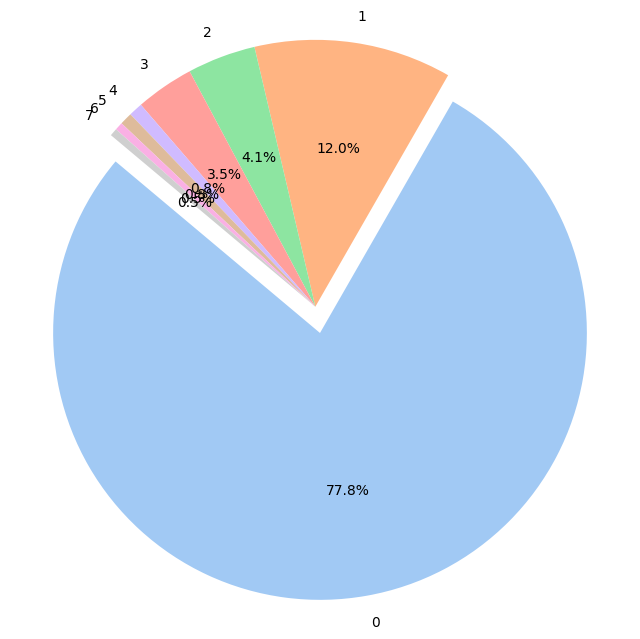

In [24]:
# SMOTE SONRASI LABEL DAGILIMI
label = y_train.value_counts().head(10)
explode_values = (0.1, 0, 0, 0, 0, 0, 0, 0)

plt.figure(figsize=(8, 8))
plt.pie(label, labels=label.index, autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette('pastel'), explode=explode_values)
plt.axis('equal')
plt.show()

In [25]:
y_pred = xgb_classifier.predict(X_test)

In [26]:
sample_submission = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/sample_submission.csv")

test_ids = df_test['MUSTERI_ID']

reverse_label_map = {0: 'UA', 1: 'HU14', 2: 'HU07', 3: 'HU06', 4: 'HU19', 5: 'HU12', 6: 'HU11', 7: 'HU15'}

test_preds_original = pd.Series(y_pred).map(reverse_label_map).values

In [27]:
submission = pd.DataFrame({'MUSTERI_ID': test_ids, 'LABEL': test_preds_original})
submission = submission.set_index('MUSTERI_ID')
submission = submission.reindex(index=sample_submission['MUSTERI_ID'])
submission = submission.reset_index()
submission.to_csv('submission.csv', index=False)